# Lab 7: Time-series Anomaly Detection



Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [1]:
!pip install pandas==1.5.3
!pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 824.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00


## Import and settings

In [4]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.7 MB/s eta 0:00:00


In [5]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold

#ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/TeachingAndThesis/MLinAPP/2023/data/Kuka_v1/normal"
#ROOTDIR_DATASET_NORMAL = "/home/bitman/Scrivania/machine_learning_in_applications/Labs-FP/dataset/Kuka_v1/normal"
ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/normal"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [7]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Introduction

You will use the dataset provided in the first Lab, concerning time series.

In such Lab1, we built a model able to classify the action that is performing a Kuka robot.

Now, we will explore Time Series Anomaly Detection (TAD), hence considering also the data contained in the collinsion foder.

This function loads sensor readings and the correspondig metadata.
The output is a dataframe grouped by action.

In [8]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

Load all data (and metadata) for frequency = 10 Hz for the normal time series

In [9]:
!ls {ROOTDIR_DATASET_NORMAL}

dataset.csv			      rec3_20220811_rbtc_0.005s.csv
rec0_20220811_rbtc_0.005s.csv	      rec3_20220811_rbtc_0.005s.metadata
rec0_20220811_rbtc_0.005s.metadata    rec3_20220811_rbtc_0.01s.csv
rec0_20220811_rbtc_0.01s.csv	      rec3_20220811_rbtc_0.01s.metadata
rec0_20220811_rbtc_0.01s.metadata     rec3_20220811_rbtc_0.1s.csv
rec0_20220811_rbtc_0.1s.csv	      rec3_20220811_rbtc_0.1s.metadata
rec0_20220811_rbtc_0.1s.metadata      rec3_20220811_rbtc_1.0s.csv
rec0_20220811_rbtc_1.0s.csv	      rec3_20220811_rbtc_1.0s.metadata
rec0_20220811_rbtc_1.0s_metadata.csv  rec4_20220811_rbtc_0.005s.csv
rec2_20220811_rbtc_0.005s.csv	      rec4_20220811_rbtc_0.005s.metadata
rec2_20220811_rbtc_0.005s.metadata    rec4_20220811_rbtc_0.01s.csv
rec2_20220811_rbtc_0.01s.csv	      rec4_20220811_rbtc_0.01s.metadata
rec2_20220811_rbtc_0.01s.metadata     rec4_20220811_rbtc_0.1s.csv
rec2_20220811_rbtc_0.1s.csv	      rec4_20220811_rbtc_0.1s.metadata
rec2_20220811_rbtc_0.1s.metadata      rec4_20220811_rbtc_1.0s.csv
rec

In [10]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [11]:
df_action.head(2)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ,time,action,duration
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:09:50.319,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.87,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.319094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052
2022-08-11 13:09:50.419,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.88,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.419094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052


# Features extraction

We will leverage [Time Series Feature Extraction Library (TSFEL)](https://tsfel.readthedocs.io/en/latest/), to extract features from time series data.

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=int(frequency * 10))]
    X['duration'] = 10
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [13]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 192.0157127380371 seconds ---


Prepare data for train and test

Note that:

*   the last three columns are the start, the end and the label corresponding to the action the robot is performing. Label is our gound truth, start and end can be dropped for the moment.
*   set NaN valuesto 0.




In [14]:
df_features.isnull().values.any()

True

In [15]:
df_features_nonan = df_features.fillna(0)

In [16]:
df_train, df_test = train_test_split(df_features_nonan)

In [17]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [18]:
#X_train.head(4)
#X_train.columns
#X_train.index
#X_train.shape
df_train.head(4)

,machine_nameKuka Robot_apparent_power-_Absolute energy,machine_nameKuka Robot_apparent_power-_Average power,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1,machine_nameKuka Robot_apparent_power-_ECDF Percentile_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile_1,machine_nameKuka Robot_apparent_power-_ECDF_0,machine_nameKuka Robot_apparent_power-_ECDF_1,machine_nameKuka Robot_apparent_power-_ECDF_2,machine_nameKuka Robot_apparent_power-_ECDF_3,...,sensor_id5_GyroZ-_Median absolute deviation,sensor_id5_GyroZ-_Min,sensor_id5_GyroZ-_Peak to peak distance,sensor_id5_GyroZ-_Root mean square,sensor_id5_GyroZ-_Skewness,sensor_id5_GyroZ-_Standard deviation,sensor_id5_GyroZ-_Variance,start,end,label
0,4.170536e+06,468599.575071,18.0,72.0,191.378174,261.080566,0.011111,0.022222,0.033333,0.044444,...,25.845,0.0,3999.94,2483.290614,0.455789,1935.597692,3.746538e+06,2022-08-11 16:03:12.591,2022-08-11 16:03:21.572,3
0,5.163084e+06,473677.474556,22.0,88.0,205.842163,221.127228,0.009091,0.018182,0.027273,0.036364,...,23.715,0.0,3999.94,2431.204227,0.526451,1920.264139,3.687414e+06,2022-08-11 15:42:00.781,2022-08-11 15:42:11.787,17
0,4.163267e+06,467782.855390,18.0,72.0,184.327042,250.680008,0.011111,0.022222,0.033333,0.044444,...,69.700,0.0,3999.94,2911.916966,-0.133661,1981.907491,3.927957e+06,2022-08-11 16:06:42.506,2022-08-11 16:06:51.519,11
0,4.408964e+06,495389.216186,18.0,72.0,183.971893,262.098206,0.011111,0.022222,0.033333,0.044444,...,1.895,0.0,3999.94,2178.206890,0.872776,1817.756245,3.304238e+06,2022-08-11 13:32:32.176,2022-08-11 13:32:41.184,3


In [19]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

# Assignment #1: Train a Bayesian MLP

Here we will train a Bayesian MLP able to provide a reliable uncertainty metric.
We will use [keras tuner](https://keras.io/keras_tuner/) to tune the huperparameters of such model.

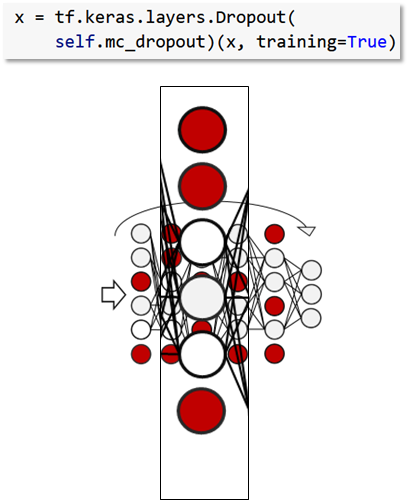

In [20]:
# Create the MLP tf model

def make_model(num_layers, units, dropouts, lr):
    model = tf.keras.Sequential()

    for i in range(num_layers):
        model.add(
            tf.keras.layers.Dense(
                units = units[i],
                activation = "relu",
                name=f"unit_{i+1}"
            )
        )
        model.add(tf.keras.layers.Dropout(rate = dropouts[i], name=f"dropout_{i+1}"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation="softmax", name="predictions"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def build_model(hp):
    num_layers = hp.Int("num_layers", 1, 5)
    units = [hp.Choice(f"unit_{i+1}", [32, 64, 128, 256, 512]) for i in range(num_layers)]
    dropouts = [hp.Choice(f"dropout_rate{i+1}", [0.1, 0.25, 0.5, 0.75]) for i in range(num_layers)]
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-1, step=10, sampling="log")

    return make_model(num_layers, units, dropouts, lr )

In [21]:
OUTPUT_DIR = os.path.join(os.getcwd(), "models")

try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError:
    pass

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="accuracy",
    project_name="bayesian_MLP",
    directory = OUTPUT_DIR,
    overwrite=True,
    max_epochs=50,
    factor=3,
)

tuner.search_space_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=15)
tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(OUTPUT_DIR, "tmp/tb_logs"))

tuner.search(X_train, y_train_categorical, callbacks = [early_stopping, tensorboard], epochs=50)

Trial 90 Complete [00h 00m 12s]
accuracy: 0.5912208557128906

Best accuracy So Far: 1.0
Total elapsed time: 00h 05m 05s


In [22]:
classifier = tuner.get_best_models()[0]

y_test_predict = classifier.predict(X_test.values)

8/8 [==============================] - 0s 3ms/step


Check the model performance

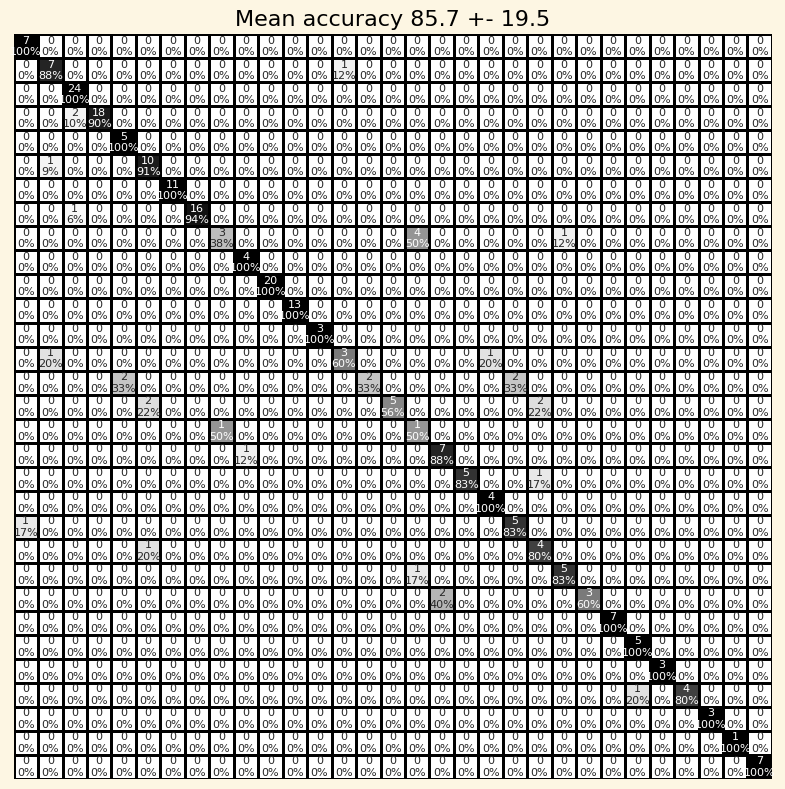

In [23]:
cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v:k for k, v in action2int.items()}
seaborn_cm(cm, ax, [int2action[l] for l in action2int.values()], fontsize=8, xrotation=90)
plt.tight_layout()

Here we implement a wrapper to compute uncertainty metrics (see Lab6)

In [24]:
class Confidence:

    def __init__(self, multiple_preds):
        self.multiple_preds = multiple_preds
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def compute_uncertainty_metrics(self):
        return {metric: self._compute_uncertainty(
            metric,
            self.multiple_preds) for metric in self._uncertainty_metrics.keys()}

    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    # def predict_many_times(self, inputs, draws=2):
    #     return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

def anomaly_detection_metric(anomaly_start_timestamps, confidence, df_dataset, thresholds, less_than=True):
    "Actual is y axis"
    if not less_than:
        confidence = 1 - confidence

    sens = list()
    spec = list()
    fpr = list()
    f1 = list()
    prec = list()
    cm_list = list()
    anomaly_indexes_dict = dict()
    acc_with_err = list()
    for threshold in thresholds:
        df_not_confident = df_dataset[confidence <= threshold]
        tp = 0
        anomaly_indexes = list()
        for anomaly in anomaly_start_timestamps:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_dataset)
        n_not_collisions = n_samples - len(anomaly_start_timestamps)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(anomaly_start_timestamps) - tp
        tn = n_not_collisions - fp

        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        cm_list.append(cm_anomaly)
        sens.append(tp / (tp + fn))
        recall = tp / (tp + fn)
        prec.append(tp / (tp + fp))
        spec.append(tn / (fp + tn))
        fpr.append(1 - tn / (fp + tn))
        try:
            f1.append(2*tp / (2*tp + fp + fn))
        except ZeroDivisionError:
            f1.append(0)
        cm_anomaly_norm = cm_anomaly.astype('float') / cm_anomaly.sum(axis=1)[:, np.newaxis]
        acc_with_err.append((np.mean(np.diag(cm_anomaly_norm)),
                            np.std(np.diag(cm_anomaly_norm))))

        anomaly_indexes_dict[threshold] = anomaly_indexes
    return sens, spec, fpr, f1, cm_list, anomaly_indexes_dict, acc_with_err, prec

In [25]:
n_mc = 10
preds_list = [classifier.predict(X_test.values, verbose=0) for n in range(n_mc)]

preds_array = np.array(preds_list)
preds_array.shape

preds_bayes_mean = preds_array.mean(axis=0)
preds_bayes_mean.shape

(244, 31)

In [26]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test),: ]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test),: ]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


PLot the distribution for correct and wrong predictiond

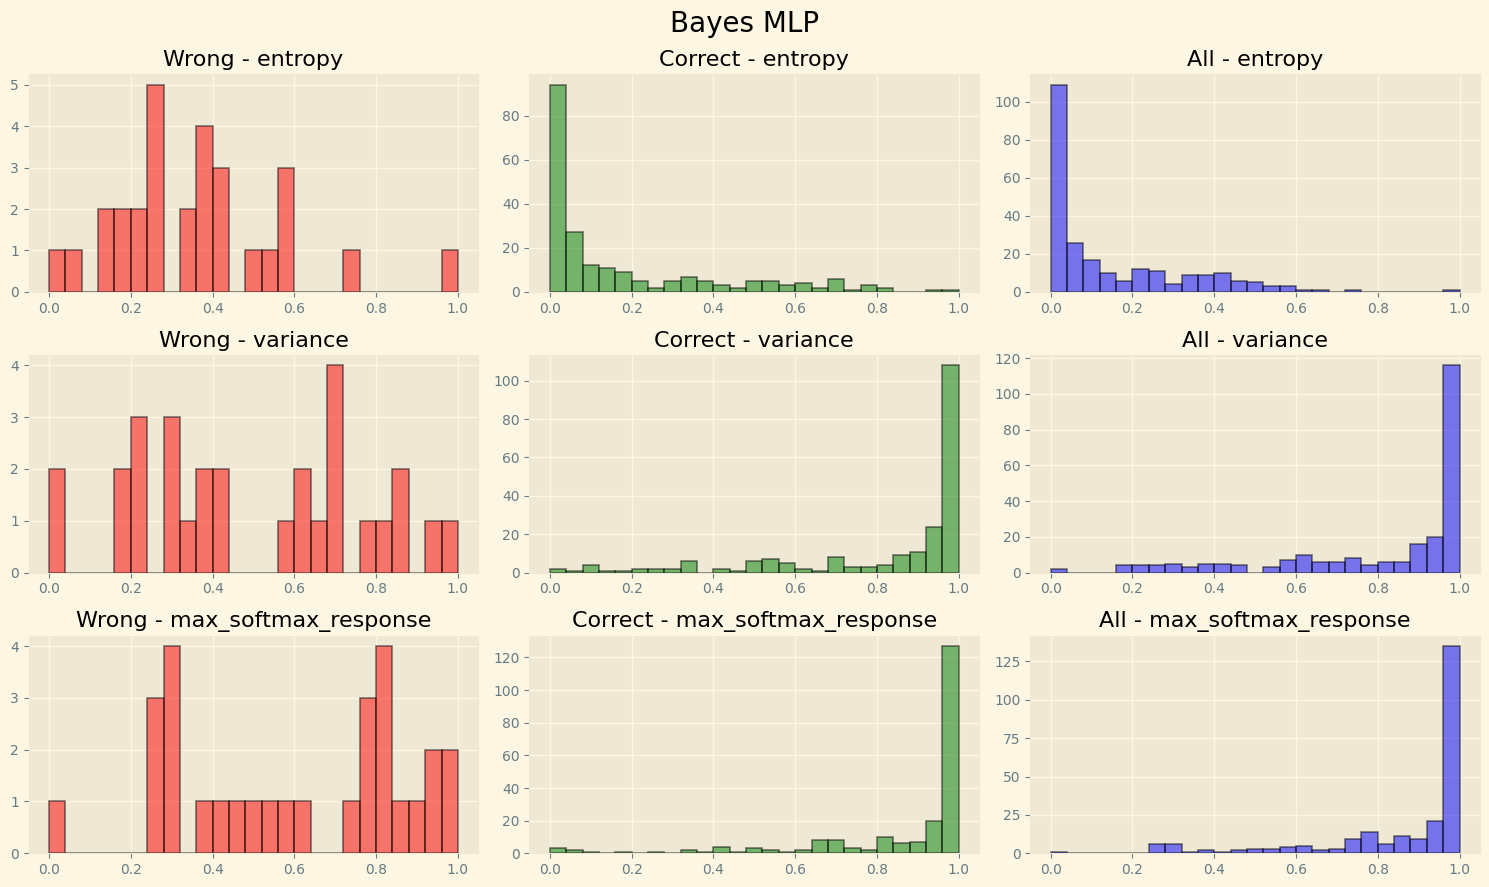

In [27]:
fig, axes = plt.subplots(len(uncertainties_bayes["correct"].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes["correct"].keys()):
    ax[0].set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes["wrong"][measure], color="red", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
    ax[1].set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes["correct"][measure], color="green", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
    ax[2].set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes["all"][measure], color="blue", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
fig.suptitle("Bayes MLP", fontsize=20)
plt.tight_layout()

# Load collisions and extract features

In [28]:
#ROOTDIR_DATASET_ANOMALY = "/content/drive/MyDrive/TeachingAndThesis/MLinAPP/2023/data/Kuka_v1/collisions"
#ROOTDIR_DATASET_ANOMALY = "/home/bitman/Scrivania/machine_learning_in_applications/Labs-FP/dataset/Kuka_v1/collisions"
ROOTDIR_DATASET_ANOMALY = "/content/drive/MyDrive/collisions"

In [29]:
!ls {ROOTDIR_DATASET_ANOMALY}

20220811_collisions_timestamp.xlsx
rec1_collision_20220811_rbtc_0.005s.csv
rec1_collision_20220811_rbtc_0.005s.metadata
rec1_collision_20220811_rbtc_0.01s.csv
rec1_collision_20220811_rbtc_0.01s.metadata
rec1_collision_20220811_rbtc_0.1s.csv
rec1_collision_20220811_rbtc_0.1s.metadata
rec1_collision_20220811_rbtc_1.0s.csv
rec1_collision_20220811_rbtc_1.0s.metadata
rec5_collision_20220811_rbtc_0.005s.csv
rec5_collision_20220811_rbtc_0.005s.metadata
rec5_collision_20220811_rbtc_0.01s.csv
rec5_collision_20220811_rbtc_0.01s.metadata
rec5_collision_20220811_rbtc_0.1s.csv
rec5_collision_20220811_rbtc_0.1s.metadata
rec5_collision_20220811_rbtc_1.0s.csv
rec5_collision_20220811_rbtc_1.0s.metadata


Note that we have a discrepancy between time in the lab where the data were collected and the PC which stored them. This line fix it.

In [30]:
collisions = pd.read_excel(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [31]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 16:02:17.450
1,f,2022-08-11 16:02:21.460
2,i,2022-08-11 16:02:28.320
3,f,2022-08-11 16:02:31.420
4,i,2022-08-11 16:02:45.770
...,...,...
97,f,2022-08-11 19:09:28.580
98,i,2022-08-11 19:09:38.750
99,f,2022-08-11 19:09:42.830
100,i,2022-08-11 19:09:53.950


In [32]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [33]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 61.22972106933594 seconds ---


Preprocessing

In [34]:
df_features_collision.isnull().values.any()

True

In [35]:
df_features_collision_nonan = df_features_collision.fillna(0)

In [36]:
X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

In [37]:
X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

# Assignment #2: Compute uncertainty

In [38]:
preds_list_collision = [classifier.predict(X_collision.values, verbose=0) for n in range(n_mc)]

In [39]:
preds_array_collisions = np.array(preds_list_collision)
preds_bayes_mean_collision = preds_array_collisions.mean(axis=0)
preds_bayes_mean_collision.shape

(306, 31)

In [40]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collision),: ]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collision),: ]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


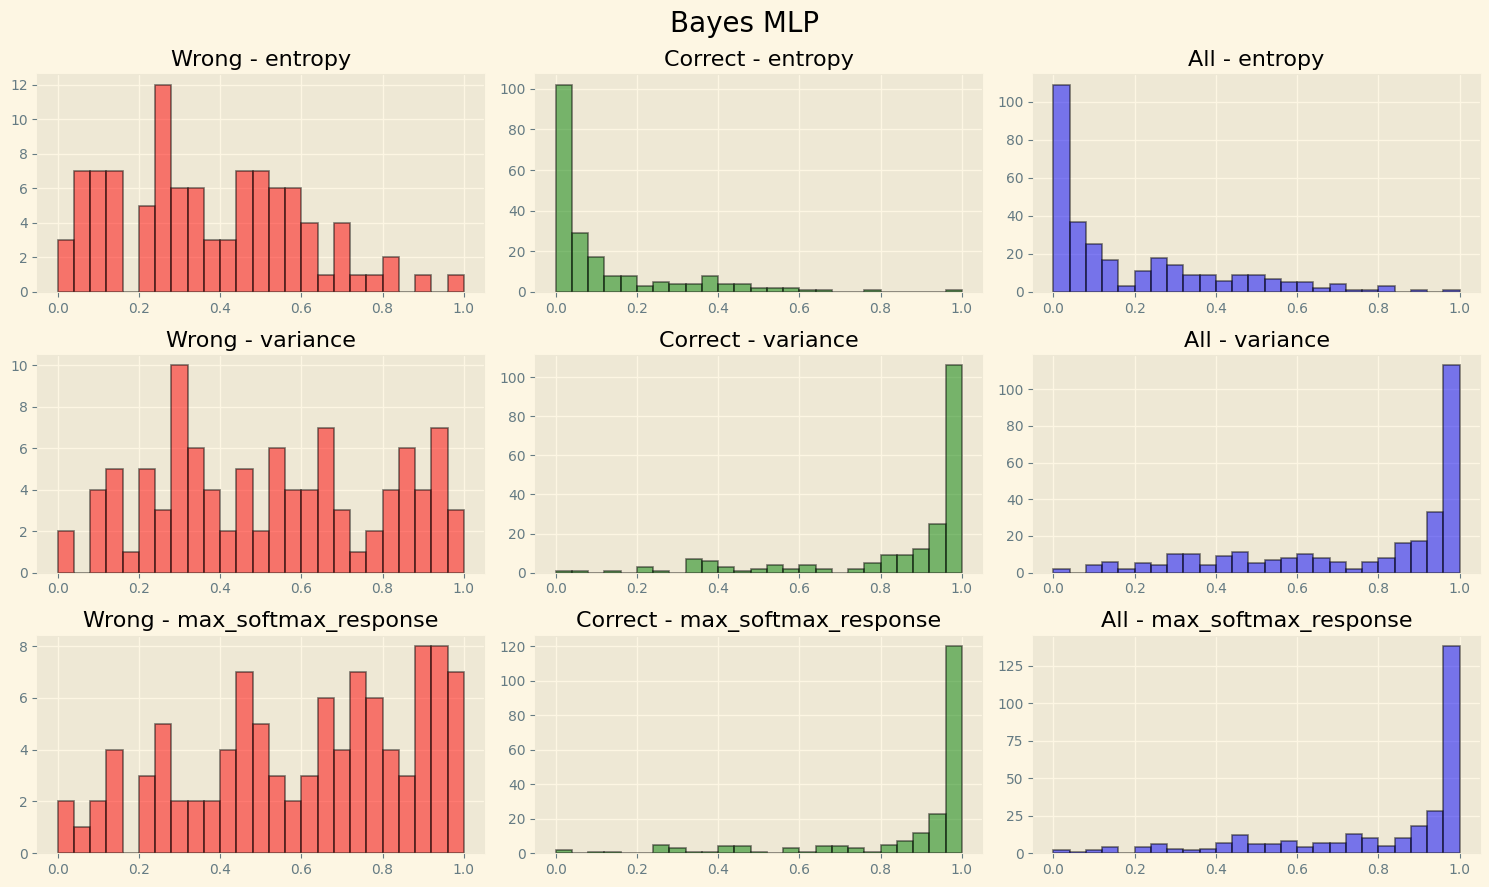

In [41]:
fig, axes = plt.subplots(len(uncertainties_bayes["correct"].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes["correct"].keys()):
    ax[0].set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes["wrong"][measure], color="red", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
    ax[1].set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes["correct"][measure], color="green", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
    ax[2].set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes["all"][measure], color="blue", log=False, bins=25, edgecolor="black", linewidth=1.2, alpha=0.5)
fig.suptitle("Bayes MLP", fontsize=20)
plt.tight_layout()

# Assignment #3:  Assess TAD algorithm performance via ROC curves

Consider that unconfident predictions will show an uncertainty above a given threshold

In [42]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes["correct"].keys():
    confidence = uncertainties_bayes["all"][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1 - confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row["start"] and anomaly <= row["end"]:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn

        sens.append(tp / (tp + fn))
        fpr.append(1-tn /(fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

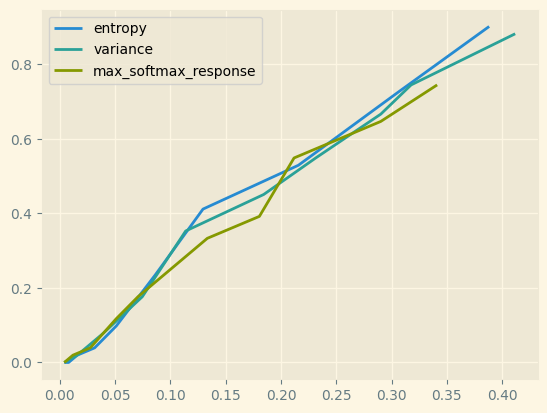

In [43]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes["correct"].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend()

## Compute and plot F1, Precision and Recall scores for different thresholds

In [44]:
interval_events = df_features_collision_nonan.loc[:, "start":"end"]

In [45]:
interval_events
def get_anomalous_intervals(path, sheet_names):
    # outputs dataframe with:
    #   - index: 0, 1, 2, 3, ...
    #   - columns: "start_timestamp", "end_timestamp"
    # Each row in this dataframe corresponds to a certain anomaly interval
    df_list = []
    begin_index = 0
    for sn in sheet_names:
        rec_collision_timestamps_excel = pd.read_excel(path, sheet_name=sn)

        starts = rec_collision_timestamps_excel.iloc[::2]
        starts.index = [i + begin_index for i in range(len(starts.index))]
        starts = starts.rename(columns={"Timestamp": "start_timestamp"})
        starts['start_timestamp'] = starts['start_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        stops = rec_collision_timestamps_excel.iloc[1::2]
        stops.index = [i + begin_index for i in range(len(stops.index))]
        stops = stops.rename(columns={"Timestamp": "end_timestamp"})
        stops['end_timestamp'] = stops['end_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        anomalous_intervals = pd.concat([starts, stops], axis=1)

        anomalous_intervals.drop('Inizio/fine', axis=1, inplace=True)
        df_list.append(anomalous_intervals)

        begin_index += len(stops.index)

    all_anomalous_intervals = pd.concat(df_list)
    return all_anomalous_intervals

def label_anomalous(interval_events, anomalous_intervals):
  def is_anomalous_interval(event_interval, anomalous_intervals):
    for _, interval in anomalous_intervals.iterrows():
      # check if lower bound of event (action) interval is within an anomalous interval
      if interval['start_timestamp'] <= event_interval['start'] and interval['end_timestamp'] >= event_interval['start']:
        return 1

      # check if upper bound of event (action) interval is within an anomalous interval
      if interval['start_timestamp'] <= event_interval['end'] and interval['end_timestamp'] >= event_interval['end']:
        return 1

      # check if whole anomalous interval is within event (action) interval
      if interval['start_timestamp'] >= event_interval['start'] and interval['end_timestamp'] <= event_interval['end']:
        return 1

    return 0

  anomaly_label = [is_anomalous_interval(event_interval, anomalous_intervals.copy()) for _, event_interval in interval_events.iterrows()]

  return np.array(anomaly_label)

In [46]:
anomalous_intervals = get_anomalous_intervals("/content/drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/csv_20220811-20220927T082743Z-001/csv_20220811/20220811_collisions_timestamp.xlsx", ["rec1", "rec5"])

In [47]:
def compute_f1_score(anomaly_scores, ground_truth, thresholds):
    f1_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        f1_dict[t] = f1_score(ground_truth, assigned_labels)

    return f1_dict

def compute_precision_score(anomaly_scores, ground_truth, thresholds):
    precision_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        precision_dict[t] = precision_score(ground_truth, assigned_labels)

    return precision_dict

def compute_recall_score(anomaly_scores, ground_truth, thresholds):
    recall_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        recall_dict[t] = recall_score(ground_truth, assigned_labels)

    return recall_dict

In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_metric(uncertainty_metric_results_dict, chosen_th_dict, model_name, metric_name, x_axis_descr, y_axis_descr, colors_dict):

  plt.figure().set_facecolor("w")
  #ax = plt.axes().set_facecolor("w")
  plt.style.use('default')

  plt.title(model_name)
  plt.xlabel(x_axis_descr)
  plt.ylabel(y_axis_descr)
  for ke in uncertainty_metric_results_dict.keys():
    metric_results_dict = uncertainty_metric_results_dict[ke]
    chosen_th = chosen_th_dict[ke]

    plt.plot(metric_results_dict.keys(), metric_results_dict.values(), '-s', linewidth=1, markersize=2, color=colors_dict[ke], label=f"{ke}")

    plt.plot(chosen_th, metric_results_dict[chosen_th], '-o', markersize=8, color=colors_dict[ke],
             label='score: {:.2f} @ chosen threshold={:.2f}'.format(metric_results_dict[chosen_th], chosen_th))

  #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
  plt.show()

def compute_metrics(uncertainty_dict, ground_truth, model_name, num_thresholds=10):

  colors_dict = {'variance': 'steelblue', 'entropy': 'orange', 'max_softmax_response': 'forestgreen'}

  thresholds = np.linspace(start=0, stop=1, num=num_thresholds)

  selected_th = dict()
  f1_res_dict = dict()
  for ke in uncertainty_dict.keys():
    print(f"\nF1 score for {ke}")
    anomaly_scores = uncertainty_dict[ke]

    f1_res = compute_f1_score(anomaly_scores, ground_truth, thresholds)
    for i in f1_res.keys():
        print(f"{i}: {f1_res[i]}")

    maxval = 0
    selected_th[ke] = 0
    for k in f1_res.keys():
      if f1_res[k] > maxval:
        maxval = f1_res[k]
        selected_th[ke] = k

    f1_res_dict[ke] = f1_res
  plot_metric(f1_res_dict, selected_th, model_name, "F1 score", "threshold", "F1 score", colors_dict)

  precision_res_dict = dict()
  for ke in uncertainty_dict.keys():
    print(f"\nPrecision score for {ke}:")
    anomaly_scores = uncertainty_dict[ke]

    precision_res = compute_precision_score(anomaly_scores, ground_truth, thresholds)
    for i in precision_res.keys():
        print(f"{i}: {precision_res[i]}")

    precision_res_dict[ke] = precision_res
  plot_metric(precision_res_dict, selected_th, model_name, "Precision score", "threshold", "Precision score", colors_dict)

  recall_res_dict = dict()
  for ke in uncertainty_dict.keys():
    print(f"\nRecall score for {ke}:")
    anomaly_scores = uncertainty_dict[ke]

    recall_res = compute_recall_score(anomaly_scores, ground_truth, thresholds)
    for i in recall_res.keys():
      print(f"{i}: {recall_res[i]}")

    recall_res_dict[ke] = recall_res
  plot_metric(recall_res_dict, selected_th, model_name, "Recall score", "threshold", "Recall score", colors_dict)

In [49]:
anomaly_label = label_anomalous(interval_events, anomalous_intervals)


F1 score for variance
0.0: 0.510948905109489
0.05263157894736842: 0.6923076923076924
0.10526315789473684: 0.7058823529411764
0.15789473684210525: 0.7241379310344829
0.21052631578947367: 0.7090909090909091
0.2631578947368421: 0.7096774193548386
0.3157894736842105: 0.6919431279620852
0.3684210526315789: 0.68
0.42105263157894735: 0.6702127659574467
0.47368421052631576: 0.6440677966101694
0.5263157894736842: 0.6279069767441859
0.5789473684210527: 0.620253164556962
0.631578947368421: 0.5810810810810811
0.6842105263157894: 0.4671532846715329
0.7368421052631579: 0.32
0.7894736842105263: 0.25
0.8421052631578947: 0.1896551724137931
0.894736842105263: 0.0909090909090909
0.9473684210526315: 0.03738317757009346
1.0: 0.01886792452830189

F1 score for entropy
0.0: 0.510948905109489
0.05263157894736842: 0.6898954703832751
0.10526315789473684: 0.7206477732793524
0.15789473684210525: 0.72
0.21052631578947367: 0.7162790697674419
0.2631578947368421: 0.7128712871287128
0.3157894736842105: 0.6777777777777

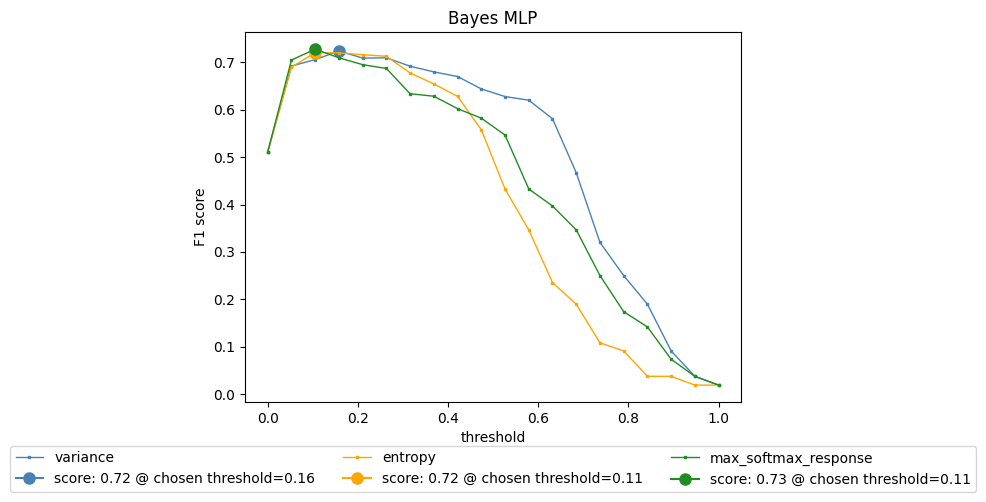


Precision score for variance:
0.0: 0.3431372549019608
0.05263157894736842: 0.5469613259668509
0.10526315789473684: 0.6
0.15789473684210525: 0.6614173228346457
0.21052631578947367: 0.6782608695652174
0.2631578947368421: 0.6875
0.3157894736842105: 0.6886792452830188
0.3684210526315789: 0.7157894736842105
0.42105263157894735: 0.7590361445783133
0.47368421052631576: 0.7916666666666666
0.5263157894736842: 0.8059701492537313
0.5789473684210527: 0.9245283018867925
0.631578947368421: 1.0
0.6842105263157894: 1.0
0.7368421052631579: 1.0
0.7894736842105263: 1.0
0.8421052631578947: 1.0
0.894736842105263: 1.0
0.9473684210526315: 1.0
1.0: 1.0

Precision score for entropy:
0.0: 0.3431372549019608
0.05263157894736842: 0.5439560439560439
0.10526315789473684: 0.6267605633802817
0.15789473684210525: 0.675
0.21052631578947367: 0.7
0.2631578947368421: 0.7422680412371134
0.3157894736842105: 0.8133333333333334
0.3684210526315789: 0.9
0.42105263157894735: 0.9607843137254902
0.47368421052631576: 0.97619047619

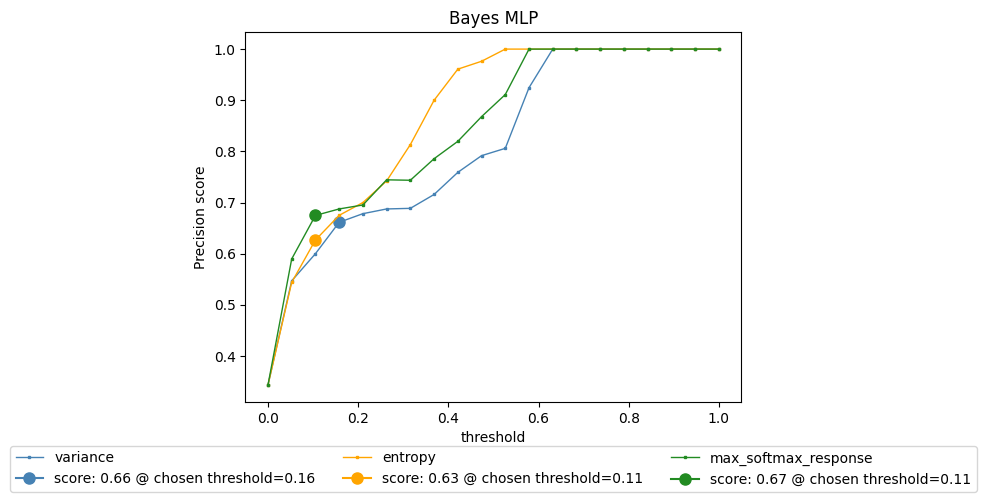


Recall score for variance:
0.0: 1.0
0.05263157894736842: 0.9428571428571428
0.10526315789473684: 0.8571428571428571
0.15789473684210525: 0.8
0.21052631578947367: 0.7428571428571429
0.2631578947368421: 0.7333333333333333
0.3157894736842105: 0.6952380952380952
0.3684210526315789: 0.6476190476190476
0.42105263157894735: 0.6
0.47368421052631576: 0.5428571428571428
0.5263157894736842: 0.5142857142857142
0.5789473684210527: 0.4666666666666667
0.631578947368421: 0.4095238095238095
0.6842105263157894: 0.3047619047619048
0.7368421052631579: 0.19047619047619047
0.7894736842105263: 0.14285714285714285
0.8421052631578947: 0.10476190476190476
0.894736842105263: 0.047619047619047616
0.9473684210526315: 0.01904761904761905
1.0: 0.009523809523809525

Recall score for entropy:
0.0: 1.0
0.05263157894736842: 0.9428571428571428
0.10526315789473684: 0.8476190476190476
0.15789473684210525: 0.7714285714285715
0.21052631578947367: 0.7333333333333333
0.2631578947368421: 0.6857142857142857
0.3157894736842105: 

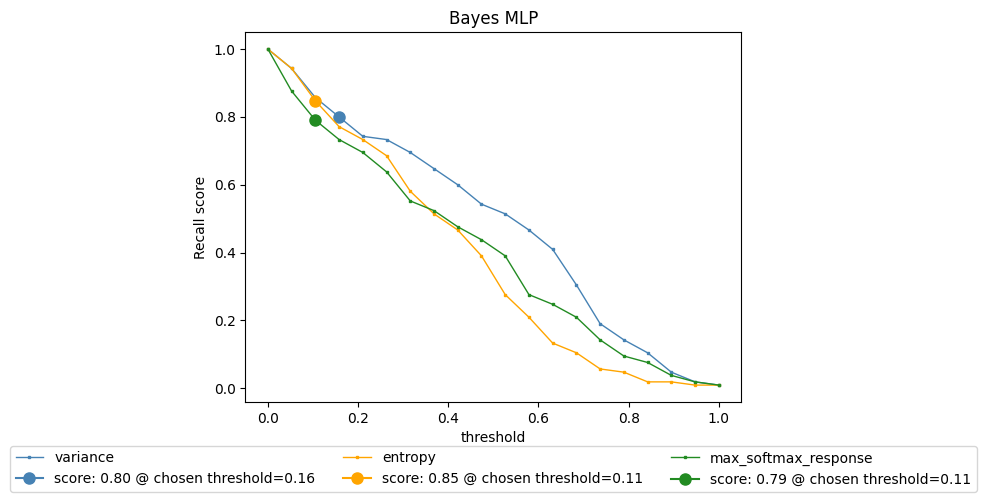

In [50]:


ub_flipped = dict()
ub_flipped['variance'] = 1 - uncertainties_bayes['all']['variance']
ub_flipped['entropy'] = uncertainties_bayes['all']['entropy']
ub_flipped['max_softmax_response'] = 1 - uncertainties_bayes['all']['max_softmax_response']
compute_metrics(ub_flipped, anomaly_label, "Bayes MLP", 20)

In [53]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes["correct"].keys():
    confidence = uncertainties_bayes["all"][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1 - confidence
    sens = list()
    fpr = list()
    #for threshold in np.arange(0, 1, 0.005):
    for threshold in np.arange(0, 1.1, 0.01):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row["start"] and anomaly <= row["end"]:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn

        sens.append(tp / (tp + fn))
        fpr.append(1-tn /(fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

Text(0.5, 1.0, 'Bayes MLP\nROC curve')

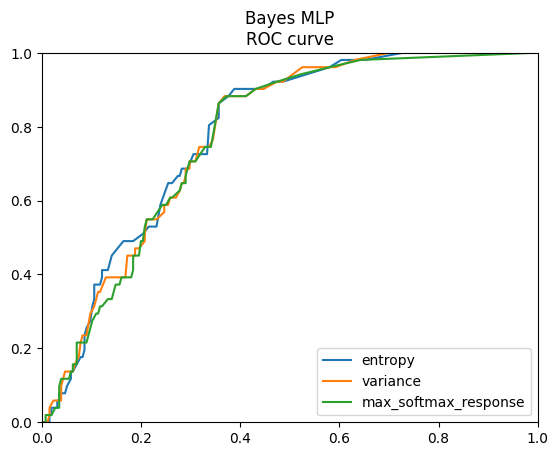

In [54]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes["correct"].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Bayes MLP\nROC curve")